Author: Aditya Anchan

Email: adijohnanc@gmail.com

Date: Nov 2022

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import laspy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.linear_model import RANSACRegressor

In [13]:
def local_ransac_plane(neighbourhood, threshold=0.1):
    """ 
    Fits a plane to a neighbourhood of points using RANSAC.

    Args:
        neighbourhood (np.array): Array of points of shape (n, 3)
        threshold (float): Distance threshold for inliers
    
    Returns:
        inlier_mask (np.array): Boolean array of shape (n,) indicating inliers
        plane_coef (np.array): Array of shape (3,) containing the plane coefficients
        intercept (float): Intercept of the plane

    """

    if len(neighbourhood) <= 10:
        return  None, None, None

    XY = neighbourhood[:,:2]
    Z = neighbourhood[:,2]

    ransac = RANSACRegressor(residual_threshold=threshold)
    ransac.fit(XY, Z)

    inlier_mask = ransac.inlier_mask_
    plane_coef = ransac.estimator_.coef_
    intercept = ransac.estimator_.intercept_

    return inlier_mask, plane_coef, intercept


def local_ransac_line(neighbourhood, threshold=0.1):
    """ 
    Fits a line to a neighbourhood of points using RANSAC in 2D.

    Args:
        neighbourhood (np.array): Array of points of shape (n, 2)
        threshold (float): Distance threshold for inliers
    
    Returns:
        line_inlier_mask (np.array): Boolean array of shape (n,) indicating inliers
        line_coef (np.array): Array of shape (1, 1) containing the line coefficients
        line_intercept (np.array): Array of shape (1, 1) containing the line intercept    
    """

    if len(neighbourhood) <= 10:
        return None, None, None
    
    x = neighbourhood[:, 0].reshape(-1, 1)
    y = neighbourhood[:, 1].reshape(-1, 1)
    
    line_ransac = RANSACRegressor(residual_threshold=threshold)
    line_ransac.fit(x, y)

    line_inlier_mask = line_ransac.inlier_mask_
    line_coef = line_ransac.estimator_.coef_
    line_intercept = line_ransac.estimator_.intercept_

    return line_inlier_mask, line_coef, line_intercept


def local_line_segment(neighbourhood, plane_threshold=0.1, line_threshold=0.1):
    """ 
    Fits a line segments over local set of points in 3D.add()

    Args:
        neighbourhood (np.array): Array of points of shape (n, 3)
        plane_threshold (float): Distance threshold for inliers in plane fitting
        line_threshold (float): Distance threshold for inliers in line fitting
    
    Returns:
        segment_3d (np.array): Array of shape (2, 3) containing the start and end points of the line segment
        plane_inlier_mask (np.array): Boolean array of shape (n,) indicating inliers in plane fitting
        line_inlier_mask (np.array): Boolean array of shape (n,) indicating inliers in line fitting
    """


    plane_inlier_mask, plane_coef, plane_intercept = local_ransac_plane(neighbourhood, threshold=plane_threshold)
    
    if plane_intercept == None:
        return None, None, None

    # Project onto plane
    plane_normal = np.array([-plane_coef[0], -plane_coef[1], 1]) # Normal vector of the plane
    plane_normal = plane_normal/np.linalg.norm(plane_normal) # Normalize

    plane_inliers = neighbourhood[plane_inlier_mask] 
    inlier_point_vectors = plane_inliers - plane_inliers[0]

    rand_vector = np.array([2, -5, 3]) # Random vector to get a perpendicular vector to the plane normal
    rand_vector = rand_vector/np.linalg.norm(rand_vector)
    
    u = np.cross(plane_normal, rand_vector) # Perpendicular vector to the plane normal
    u = u/np.linalg.norm(u) 

    v = np.cross(plane_normal, u) # Perpendicular vector to the plane normal and u
    v = v/np.linalg.norm(v)

    UV_transform = np.array([u, v]).T 

    d_u = np.dot(inlier_point_vectors, u) # u and v coordinates on projected plane, run ransac on these points in 2d to get line
    d_v = np.dot(inlier_point_vectors, v)

    d_uv = np.array([d_u, d_v]).T

    # ransac on 2D u and v data
    line_inlier_mask, line_coef, line_intercept = local_ransac_line(d_uv, threshold=line_threshold) 

    if line_intercept == None:
        return None, None, None

    x0 = min(d_u[line_inlier_mask]) # Start point of line segment
    x1 = max(d_u[line_inlier_mask]) # End point of line segment

    y0 = line_coef[0][0]*x0 + line_intercept[0] # y coordinate of start point
    y1 = line_coef[0][0]*x1 + line_intercept[0] # y coordinate of end point

    segment_2d = np.array([[x0, y0], [x1, y1]]) # Line segment in 2D
    segment_3d = (UV_transform @ segment_2d.T).T # Line segment in 3D

    segment_3d = segment_3d + plane_inliers[0] # go back to original frame of reference translation

    return segment_3d, plane_inlier_mask, line_inlier_mask

def line_tracing(data, k_neighbours=100, plane_threshold=0.05, line_threshold=0.05):
    """ 
    Performs line tracing over a set of 3D edge points
    """

    if k_neighbours > len(data):
        print("k is too large for this data")
        return

    line_segments = []
    distance_tree = KDTree(data)
    
    outlier_mask = np.full(len(data), True)

    for idx, point in enumerate(data):
        index_list = np.array(range(len(data)))
        inlier_mask = np.full(len(data), False)

        local_points_idx = distance_tree.query(point, k=k_neighbours, p=2)[1]
        local_points_mask = np.full(len(data), False)

        local_points_mask[local_points_idx] = True
        local_points = data[outlier_mask & local_points_mask]

        index_list = index_list[outlier_mask & local_points_mask]

        line, plane_inlier_mask, line_inlier_mask = local_line_segment(local_points, plane_threshold=plane_threshold, line_threshold=line_threshold)
        
        index_list = index_list[plane_inlier_mask]
        index_list = index_list[line_inlier_mask]

        inlier_mask[index_list] = True

        outlier_mask = outlier_mask & ~inlier_mask

        if type(line) != np.ndarray:
            continue

        line_segments.append(line)

    return line_segments




# Plotting Functions

In [14]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap,label='Test')
    plt.show()

def scatter3d_p(x,y,z):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z)

    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])


    plt.show()


# Simulate Data

In [15]:
def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))


def generate_box(samples_per_side=100, error=0.05, height=1):
    # generate box
    surface_base = np.random.uniform(low=[-0.5, -0.5, 0-error], high=[0.5, 0.5, 0+error], size=(samples_per_side, 3))
    surface_top = np.random.uniform(low=[-0.5, -0.5, height-error], high=[0.5, 0.5, height+error], size=(samples_per_side, 3))
    
    surface_side_1 = np.random.uniform(low=[-0.5-error, -0.5-error, 0-error], high=[-0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))
    surface_side_2 = np.random.uniform(low=[-0.5-error, -0.5-error, 0-error], high=[0.5+error, -0.5+error, height+error], size=(samples_per_side, 3))

    surface_side_3 = np.random.uniform(low=[0.5-error, -0.5-error, 0-error], high=[0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))
    surface_side_4 = np.random.uniform(low=[-0.5-error, 0.5-error, 0-error], high=[0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))


    surface_data = np.append(surface_base, surface_top, axis=0)
    surface_data = np.append(surface_data, surface_side_1, axis=0)
    surface_data = np.append(surface_data, surface_side_2, axis=0)
    surface_data = np.append(surface_data, surface_side_3, axis=0)
    surface_data = np.append(surface_data, surface_side_4, axis=0)

    # generate edge mask

    edge_mask = np.full(samples_per_side*6, False)

    for idx, point in enumerate(surface_data):
        if lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, 0.5, 0]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
    

    return surface_data, edge_mask


def generate_cylinder(samples=1000, error=0.02):
    points = np.zeros((samples, 3))

    idx = 0
    for i in range(10000000):
        sample_point = np.random.uniform(low=[-1, -1, 0], high=[1.0, 1.0, 1], size=3)

        if ((0.5-error)**2 <= sample_point[0]**2 + sample_point[1]**2 <= 0.5**2) and (0 <= sample_point[2] <= 1):
            if idx >= samples:
                print(i)
                break
            else:
                points[idx] = sample_point
                idx += 1

    # edge mask
    edge_mask = np.full(len(points), False)
    for idx, point in enumerate(points):
        if ((0.5-error)**2 <= point[0]**2 + point[1]**2 <= 0.5**2) and (1-error <= point[2] <= 1+error or -error <= point[2] <= error):
        # if ((0.5-error)**2 <= point[0]**2 + point[1]**2 <= 0.5**2):
            edge_mask[idx] = True

                
    return points, edge_mask



def z_rotation_matrix(theta):
    R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    return R

def generate_box_curved(samples_per_side=100, error=0.05, height=3):
    surface_base = np.random.uniform(low=[-0.5, -0.5, 0-error], high=[0.5, 0.5, 0+error], size=(samples_per_side, 3))
    surface_top = np.random.uniform(low=[-0.5, -0.5, height-error], high=[0.5, 0.5, height+error], size=(samples_per_side, 3))
    
    surface_side_1 = np.random.uniform(low=[-0.5-error, -0.5-error, 0-error], high=[-0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))
    surface_side_3 = np.random.uniform(low=[0.5-error, -0.5-error, 0-error], high=[0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))


    surface_data = np.append(surface_base, surface_top, axis=0)
    surface_data = np.append(surface_data, surface_side_1, axis=0)
    surface_data = np.append(surface_data, surface_side_3, axis=0)

    # generate mask
    edge_mask = np.full(samples_per_side*4, False)

    for idx, point in enumerate(surface_data):
        if lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, 0.5, 0]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True

    # transform prism
    points = np.zeros((4*samples_per_side, 3))

    for idx in range(4*samples_per_side):
        z_value = surface_data[idx][2].copy()
        angle_rot = np.pi/4 * z_value/height

        points[idx] = z_rotation_matrix(angle_rot) @ surface_data[idx]


    return points, edge_mask


def sample_triangle_points(pt1, pt2, pt3, samples=100):
    triangle_samples = np.zeros((samples, 3))

    for i in range(samples):
        a, b = np.random.random(), np.random.random()

        if a + b >= 1:
            a = 1-a
            b = 1-b

        x = pt1 + a*(pt2-pt1) + b*(pt3-pt1)
        triangle_samples[i] = x
        
    
    return triangle_samples


def generate_pyramid(samples_per_side=100, error=0):
    surface_base = np.random.uniform(low=[-0.5, -0.5, 0-error], high=[0.5, 0.5, 0+error], size=(samples_per_side, 3))

    pt1 = np.array([0, 0, 1])
    pt2 = np.array([0.5, -0.5, 0])
    pt3 = np.array([-0.5, -0.5, 0])
    pt4 = np.array([-0.5, 0.5, 0])
    pt5 = np.array([0.5, 0.5, 0])

    triangle1 = sample_triangle_points(pt1, pt2, pt3, samples=samples_per_side)
    triangle2 = sample_triangle_points(pt1, pt3, pt4, samples=samples_per_side)
    triangle3 = sample_triangle_points(pt1, pt4, pt5, samples=samples_per_side)
    triangle4 = sample_triangle_points(pt1, pt5, pt2, samples=samples_per_side)

    triangle_data = np.append(surface_base, triangle1, axis=0)
    triangle_data = np.append(triangle_data, triangle2, axis=0)
    triangle_data = np.append(triangle_data, triangle3, axis=0)
    triangle_data = np.append(triangle_data, triangle4, axis=0)

    edge_mask = np.full(len(triangle_data), False)
    for idx, point in enumerate(triangle_data):
        if lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([-0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

    return triangle_data, edge_mask

## Generate Data

In [16]:
box1, box_mask = generate_box(samples_per_side=1000, error=0.05, height=3)

x_scale = 0.6
y_scale = 0.6
box_transform = np.array([[1, 0, x_scale], [0, 1, y_scale], [0, 0, 1]])

box1 = (box_transform @ box1.T).T[box_mask]

In [17]:
cylinder1, cylinder_mask = generate_cylinder(samples=4000, error=0.04)

x_scale = 0.6
y_scale = 0.6
cylinder_transform = np.array([[1, 0, x_scale], [0, 1, y_scale], [0, 0, 1]])

cylinder1 = (cylinder_transform @ cylinder1.T).T[cylinder_mask]

131715


In [18]:
curved_box1, curved_mask = generate_box_curved(samples_per_side=1000, error=0.05, height=3)

x_scale = 0.6
y_scale = 0.6
curved_transform = np.array([[1, 0, x_scale], [0, 1, y_scale], [0, 0, 1]])

curved_box1 = (curved_transform @ curved_box1.T).T[curved_mask]

In [19]:
pyramid1, pyramid_mask = generate_pyramid(samples_per_side=1000, error=0.05)
pyramid1 = pyramid1[pyramid_mask].copy()

## Line tracing for data

### Box

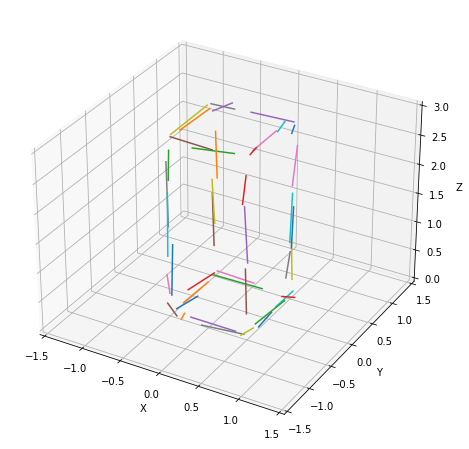

In [20]:
line_segments = line_tracing(box1, k_neighbours=50, plane_threshold=0.05, line_threshold=0.05)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-0, 3])

line_data_0 = (np.linalg.inv(box_transform) @ box1.T).T

for line in line_segments:
    line = (np.linalg.inv(box_transform) @ line.T).T
    ax.plot(line[:, 0], line[:, 1], line[:, 2])


### cylinder

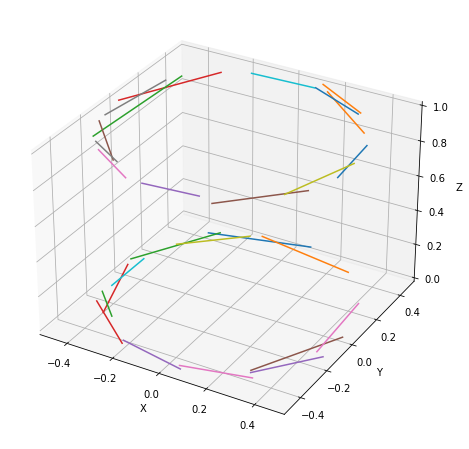

In [21]:
line_segments = line_tracing(cylinder1, k_neighbours=50, plane_threshold=0.02, line_threshold=0.02)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([0, 1])

line_data_0 = (np.linalg.inv(cylinder_transform) @ box1.T).T

for line in line_segments:

    line = (np.linalg.inv(cylinder_transform) @ line.T).T

    ax.plot(line[:, 0], line[:, 1], line[:, 2])


### Curved box

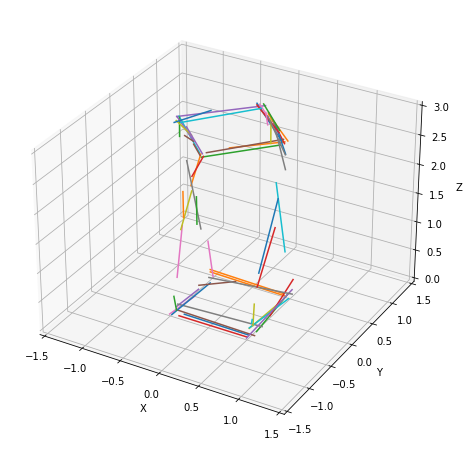

In [22]:
line_segments = line_tracing(curved_box1, k_neighbours=100, plane_threshold=0.05, line_threshold=0.02)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-0, 3])

line_data_0 = (np.linalg.inv(curved_transform) @ box1.T).T

for line in line_segments:

    line = (np.linalg.inv(curved_transform) @ line.T).T
    ax.plot(line[:, 0], line[:, 1], line[:, 2])



### Pyramid

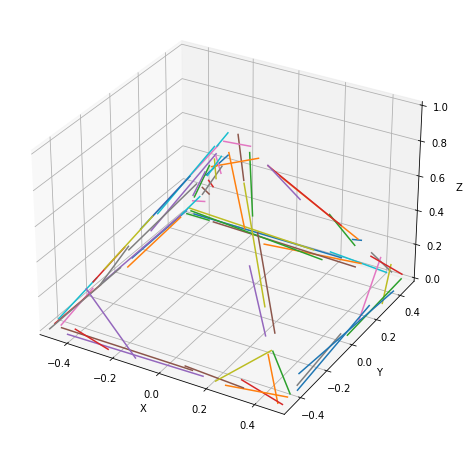

In [23]:
line_segments = line_tracing(pyramid1, k_neighbours=100, plane_threshold=0.01, line_threshold=0.02)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([0, 1])

for line in line_segments:
    
    ax.plot(line[:, 0], line[:, 1], line[:, 2])
